## Reward function

In [ ]:
import puzzle

def reward(self):
    increment = self.game.increment
    totalScore = self.game.totalScore
    # loose does not work yet
    #loose = self.game.loose
    return increment

## Neural Network Model

In [ ]:
import random
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import RMSprop

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=100000)
        self.gamma = 0.9    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.e_decay = .99
        self.e_min = 0.05
        self.learning_rate = 0.01
        self.model = self._build_model()

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(20, input_dim=self.state_size, activation='tanh')) # Adds the first layer with 16 inputs
        model.add(Dense(20, activation='tanh', init='uniform')) # Adds Hidden layer with 20 nodes
        model.add(Dense(self.action_size, activation='linear')) # Adds output layer with 2 nodes
        model.compile(loss='mse',
                      optimizer=RMSprop(lr=self.learning_rate)) # Creates the model from all of the above
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action

    def replay(self, batch_size):
        batch_size = min(batch_size, len(self.memory))
        minibatch = random.sample(self.memory, batch_size)
        X = np.zeros((batch_size, self.state_size))
        Y = np.zeros((batch_size, self.action_size))
        for i in range(batch_size):
            state, action, reward, next_state, done = minibatch[i]
            target = self.model.predict(state)[0]
            if done:
                target[action] = reward
            else:
                target[action] = reward + self.gamma * \
                            np.amax(self.model.predict(next_state)[0])
            X[i], Y[i] = state, target
        self.model.fit(X, Y, batch_size=batch_size, nb_epoch=1, verbose=0)
        if self.epsilon > self.e_min:
            self.epsilon *= self.e_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

## Main Game execution

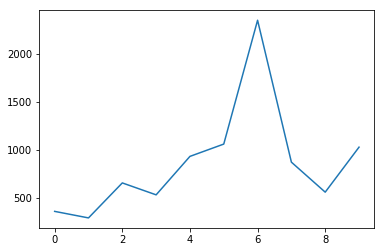

In [2]:
%matplotlib inline

import time
import puzzle
import csv
import matplotlib.pyplot as plt
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import RMSprop
import numpy as np
import random

MAX_EPISODES=10
INDEX_EPISODE=0
INDEX_EPOCH=1
INDEX_REWARD=2
INDEX_LOSS=3
INDEX_SCORE=4
INDEX_INCREMENT=5
INDEX_LOST=6
INDEX_LAST_STATE=7
INDEX_ACTION=8
INDEX_CURRENT_STATE=9
INDEX_WEIGHTS=10
#ACCESS SCORE AS self.game.score
#ACCESS MATRIX AS self.game.matrix
#DECIDE ACTION TO TAKE IN act()
#POSSIBLE ACTIONS:
#	go up:		"'w'"
#	go left:	"'a'"
#	go right:	"'s'"
#	go down:	"'d'"

class Machine:
    game=puzzle.GameGrid() # Game object
    epoch=0
    episode=0
    loss=0
    reward=0
    verbose_logging=False
    weight_logging=False
    action="'w'"
    model = Sequential()
    inputVector=np.zeros((1, 16))
    lastState=np.zeros((1, 16))
    Qvalues0=np.zeros((1,4))
    Qvalues1=np.zeros((1,4))
    acts = ["'w'","'s'","'d'","'a'"]
    gamma = 0.9    # Discount rate
    epsilon = 0.9  # Exploration rate
    
    def __init__(self, verbose_logging_in=False,weight_logging_in=False):
        self.verbose_logging=verbose_logging_in
        self.weight_logging=weight_logging_in
        # Create model
        self.model.add(Dense(20, input_dim=16, activation='tanh')) # Adds the first layer with 16 inputs
        self.model.add(Dense(20, activation='tanh'))              # Adds Hidden layer with 20 nodes (Removed 'uniform')
        self.model.add(Dense(4, activation='linear'))             # Adds output layer with 20 nodes
        self.model.compile(loss='mse',optimizer=RMSprop(lr=0.01)) # Creates the model from all of the above
        # Initialise log
        with open('../logs/log.csv', 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            if self.verbose_logging and self.weight_logging:
                writer.writerow(["EPISODE","EPOCH","REWARD","LOSS","TOTAL SCORE","INCREMENT IN SCORE","LOST","LAST STATE","ACTION","CURRENT STATE","WEIGHTS"]) 
            elif self.verbose_logging:
                writer.writerow(["EPISODE","EPOCH","LAST STATE","ACTION","CURRENT STATE","REWARD","LOSS","TOTAL SCORE","INCREMENT IN SCORE","LOST"]) 
            else:
                writer.writerow(["EPISODE","EPOCH","REWARD","LOSS","TOTAL SCORE","INCREMENT IN SCORE","LOST"]) 
    def run(self):
        # Transform game state to 1D array
        for i in range(4):
            self.inputVector[0][0+4*i:4+4*i]=self.game.matrix[i]
        self.epoch=self.epoch+1 # Increase epoch
        self.log() # Log model
        self.game.increment=self.get_reward() # Update reward if game has been lost
        self.game.key_down(self.act()) # Select action and update weights
        self.lastState=self.inputVector # For logging
        # Game loop
        self.game.update_idletasks
        self.game.update()
        # pool emaG
    def act(self):
        if random.random() <= self.epsilon:  # Exploration
            #print(" Random Action ")
            self.action = self.acts[random.randint(0,3)]
            return self.action
        else: 
            # Predict Q values of current state
            self.Qvalues1[0]=self.gamma*self.model.predict(self.inputVector)+self.game.increment
            # Update weights with respect to last step's prediction of this step's Q values
            self.loss=self.model.train_on_batch(self.inputVector, self.Qvalues0)
            # Make this step's Q values next step's past Q values
            self.Qvalues0=self.Qvalues1
            # Select action with highest Q value
            self.action=self.acts[self.Qvalues1.argmax()] # Don't delete this variable, it's used when logging
            return self.action
    def log(self):
        # Log episode, epoch, reward, error, score, increment in score, lost, previous state, action, next state, weights 
        if self.weight_logging:
            for layer in self.model.layers:
                weights = layer.get_weights() # list of numpy arrays
        with open('../logs/log.csv', 'a', newline='') as csvfile:
            writer = csv.writer(csvfile)
            if self.weight_logging and self.verbose_logging:
                writer.writerow([self.episode,self.epoch,self.reward,self.loss,self.game.score,self.game.increment,self.game.result,self.lastState,self.action,self.inputVector,weights])
            elif self.verbose_logging:
                writer.writerow([self.episode,self.epoch,self.reward,self.loss,self.game.score,self.game.increment,self.game.result,self.lastState,self.action,self.inputVector])
            else:
                writer.writerow([self.episode,self.epoch,self.reward,self.loss,self.game.score,self.game.increment,self.game.result]) 
    def plot(self):         
        with open('../logs/log.csv',newline='') as csvfile:
            reader=csv.reader(csvfile)
            # Transform reader to array
            data=list(reader) 
            # Allocate arrays
            x=[]
            y=[]
            # Get rid of labels
            a=data.pop(0)
            for row in data:
                # Search for lost games
                if row[INDEX_LOST]=="True": # Needed because it's read as a string and not a bool
                    x.append(row[INDEX_EPISODE]) # Episode
                    y.append(row[INDEX_SCORE]) # Total score     
            # Plot results
            fig, ax = plt.subplots()
            ax.plot(x, y)
    def get_reward(self):
        l=0
        if self.game.result: # If the agent lost
            l = -2*self.game.increment-self.game.score/4
            # Reset game
            self.game.reset()
            self.epoch=0
            self.episode=self.episode+1
        self.reward=self.game.increment + l # Don't delete this vriable, it's used for logging
        return (self.reward)
    
    #######################################
    # I made this function to calculate the best next step. This will be the function
    # Determening which state to be given to the neural network.
    # This is a bad implementation since it relies on copying the whole game for every
    # calculation, but it will work to train in the beginning. 
    def calculateNextStep(self, game):
        best_qval = 0
        best_move = 'up' # Default move
        acts = ['up','down','right','left']
        for act in acts: 
            game_copy = game
            game_copy.key_down(self.act(act))
            self.game.update_idletasks
            self.game.update()
            qval = game_copy.reward()
            if qval > best_qval:
                best_qval = qval
                best_move = act
        return best_move
    #######################################
        
our_machine = Machine(True)
while our_machine.episode<MAX_EPISODES:
    our_machine.run()
our_machine.plot()

In [ ]:
import numpy as np

a=np.array([[1,2,7],[3,4,5]])
b=np.array([0,0,0,0,0,0])
for i in range(2):
    b[0+3*i:3+3*i]=a[i]
print(b[b.argmax()])
print(b.shape)
x_test = np.zeros((1, 16))
print(x_test)

In [ ]:
import pyqtgraph as pg
import numpy as np
x = np.arange(1000)
y = np.random.normal(size=(3, 1000))
plotWidget = pg.plot(title="Three plot curves")
for i in range(3):
    plotWidget.plot(x, y[i], pen=(i,3))  ## setting pen=(i,3) automaticaly creates three different-colored pens

In [ ]:
with open('../logs/test.txt', 'w') as f:
    s="test"
    f.write(s)
    f.write(s)
    f.write(s)

In [ ]:
import csv
with open('../logs/log.csv',newline='') as csvfile:
    reader=csv.reader(csvfile)
    data=list(reader)


In [ ]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import csv

with open('../logs/log.csv',newline='') as csvfile:
    reader=csv.reader(csvfile)
    # Transform reader to array
    data=list(reader) 
    # Allocate arrays
    x=[]
    y=[]
    # Get rid of labels
    a=data.pop(0)
    for row in data:
        # Search for game lost
        if row[10]=="True": # Needed because it's read as a string and not a bool
            x.append(row[0]) # Episode
            y.append(row[7]) # Total score     
    # Plot results
    fig, ax = plt.subplots()
    ax.plot(x, y)


In [ ]:
import numpy as np

x=[[1,2],[3,4],[5,6]]

y=np.zeros(len(x))
print(y)
